# Project 7 - Shor’s factoring algorithm

If you want to install the dependencies, run : `pip install -r requirements.txt`
we work with `qiskit:2.2.3`

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
import matplotlib.pyplot as plt
import os
import sys

Importing functions present in `src/` :

In [2]:
sys.path.append(os.path.abspath('./src'))
from bottom_up.modular_add import modular_add
from bottom_up.modular_multiplication import modular_multiplication
from bottom_up.modular_exponentiation import modular_exponentiation
from bottom_up.bottom_up_alg import bottom_up
from compiled.compiled_alg import compiled_algorithm
from utils.simulate_modular_exponentiation import simulate_modular_exponentiation

---

## 1. Schor's algorithm

Shor’s algorithm is a quantum algorithm for factoring large integers efficiently, exponentially faster than the best-known classical algorithms. Given a composite integer N, the goal is to find its prime factors. Classical factoring is super-polynomial in time, while Shor’s algorithm works in polynomial time on a quantum computer.

The algorithm starts by picking a random integer a such that $1 < a < N$ and $\gcd(a, N) = 1$. If $\gcd(a, N) \neq 1$, a nontrivial factor of $N$ has already been found. The core quantum part is finding the order $r$ of a modulo $N$, which is the smallest positive integer satisfying $a^r \equiv 1 \pmod{N}$. Once r is known, if it is even and $a^{r/2} \not\equiv -1 \pmod{N}$, then computing $\gcd(a^{r/2} - 1, N)$ or $\gcd(a^{r/2} + 1, N)$ gives a nontrivial factor of $N$. If these conditions fail, the algorithm repeats with another a.

The quantum period-finding subroutine works by preparing a superposition of all integers x in a range [0, Q-1] where Q \ge N^2, and computing a^x \mod N in a second register. Measuring the second register collapses the state to values consistent with the measured result. Applying the Quantum Fourier Transform (QFT) on the first register transforms the periodic superposition into peaks at integer multiples of Q/r. Measuring the first register gives a value k approximately satisfying k/Q \approx j/r for some integer j. Classical continued fractions then recover the period r.

Once the period r is obtained, the classical post-processing computes \gcd(a^{r/2} \pm 1, N) to find nontrivial factors. For example, factoring N = 15 with a = 2 gives r = 4; then 2^{4/2} - 1 = 3 and 2^{4/2} + 1 = 5, yielding factors 3 and 5.

The complexity of the quantum order-finding is O((\log N)^2 (\log \log N)(\log \log \log N)), and the classical post-processing is polynomial in \log N. Overall, Shor’s algorithm is exponentially faster than classical factoring algorithms. Its power comes from reducing factoring to period finding and using quantum superposition and interference to efficiently extract the period.

---

## 2. Introduction to Modular Exponentiation (Oracle)

Explain the concept: Start by defining modular exponentiation and its role as the core task performed by the oracle in Shor’s algorithm.
Highlight its importance: Emphasize why it’s a key operation for breaking cryptographic systems like RSA.

Systematic Approach to Designing a Modular Exponentiation Circuit

Reversible Computing: Explain how to construct a modular exponentiation circuit using reversible computing, starting from a classical boolean circuit.
Key Idea: Reversible circuits are essential in quantum computing because quantum operations must be unitary (reversible).

### Concept
**Modular exponentiation** is the computation of the remainder when an integer $ b $ (the base) raised to an exponent $ e $ is divided by a positive integer $ m $ (the modulus), expressed as:
$$ b^e \mod m $$

In the context of **Shor’s algorithm**, modular exponentiation is the **core task performed by the quantum oracle**. The oracle evaluates the function:
$$ f(x) = a^x \mod N $$
where $ a $ is a randomly chosen integer coprime to $ N $, and $ x $ is the input to the oracle.

### Importance
Modular exponentiation is a **key operation** in cryptography, particularly in breaking widely used systems like **RSA**. RSA’s security relies on the difficulty of factoring large composite numbers. Shor’s algorithm leverages quantum parallelism and the Quantum Fourier Transform (QFT) to find the **period** of the modular exponentiation function, which can then be used to factor $ N $ efficiently.

### Reversible Computing
To construct a modular exponentiation circuit for quantum computing, we start from a **classical boolean circuit** and adapt it to be **reversible**. Reversible computing ensures that the circuit can be implemented using unitary operations, which are a fundamental requirement for quantum circuits.

key idea
- **Reversible Circuits:** In quantum computing, all operations must be **unitary** (i.e., reversible). This means that the circuit must be designed such that the input can be uniquely determined from the output, with no loss of information.
- **Classical to Quantum:** The process involves converting classical logic gates (e.g., AND, OR) into reversible gates (e.g., Toffoli, CNOT) and ensuring that the modular exponentiation operation adheres to these constraints.

---

## 3. Bottom-Up Approach:

The bottom-up approach builds a modular exponentiation circuit by assembling more complex arithmetic operations from simpler ones. It begins with a modular addition circuit computing $(a + b) \bmod N$, which serves as the foundation for all higher-level modular operations. From this, one constructs a modular multiplication circuit computing $(a \times b) \bmod N$, typically through repeated controlled additions and intermediate modular reductions. Finally, modular exponentiation, i.e. $a^b \bmod N$, is built using repeated squaring or iterative multiplication combined with modular reduction.

This method is general and works for any input, which makes it suitable for factoring arbitrary large integers in Shor’s algorithm. The construction follows a simple progression: start with modular addition, use it to build modular multiplication, and then use modular multiplication to obtain modular exponentiation. References [1, 2, 3, 4] describe this approach in detail.

In practice, implementing the bottom-up method consists of sequentially designing and combining the necessary arithmetic components in the order
modular addition → modular multiplication → modular exponentiation.

a. Modular Addition Circuit

Modular addition computes $(a + b) \mod N$. To implement this in a reversible way, you can use a ripple-carry adder combined with a modular reduction.

In [3]:
num_qubits = 4
constant = 3

qc_test = modular_add(num_qubits, constant=constant, verbose=True)

                                                      
a_0: ─────────────────■──────────────■────────────────
                      │              │                
a_1: ─────────────────┼────■─────────┼────■───────────
                      │    │         │    │           
a_2: ───────■─────────┼────┼────■────┼────┼───────────
            │         │    │    │    │    │           
a_3: ───────┼────■────┼────┼────┼────┼────┼───────────
     ┌───┐  │    │  ┌─┴─┐  │    │    │    │  ┌─┐      
b_0: ┤ X ├──┼────┼──┤ X ├──┼────┼────┼────┼──┤M├──────
     ├───┤  │    │  └───┘┌─┴─┐  │  ┌─┴─┐  │  └╥┘┌─┐   
b_1: ┤ X ├──┼────┼───────┤ X ├──┼──┤ X ├──┼───╫─┤M├───
     └───┘┌─┴─┐  │       └───┘  │  └───┘┌─┴─┐ ║ └╥┘┌─┐
b_2: ─────┤ X ├──┼──────────────┼───────┤ X ├─╫──╫─┤M├
          └───┘┌─┴─┐          ┌─┴─┐ ┌─┐ └───┘ ║  ║ └╥┘
b_3: ──────────┤ X ├──────────┤ X ├─┤M├───────╫──╫──╫─
               └───┘          └───┘ └╥┘       ║  ║  ║ 
c: 4/════════════════════════════════╩════════╩══╩══╩═
          

b. Modular Multiplication Circuit

Modular multiplication computes $(a×b)mod  N$. This can be implemented using repeated modular addition.

In [4]:
num_qubits = 4
a_value = 3
N = 7

qc_mul_test = modular_multiplication(num_qubits, a_value=a_value, N=N, verbose=True)

                                                                           »
     b_0: ─────────────────────────────────────────────────────────────────»
                                                                           »
     b_1: ─────────────────────────────────────────────────────────────────»
                                                                           »
     b_2: ─────────────────────────────────────────────────────────────────»
                                                                           »
     b_3: ─────────────────────────────────────────────────────────────────»
                         ┌───┐                    ┌───┐               ┌───┐»
result_0: ───────────────┤ X ├────────────────────┤ X ├───────────────┤ X ├»
                         └─┬─┘┌───┐     ┌───┐     └─┬─┘     ┌───┐     └─┬─┘»
result_1: ─────────────────┼──┤ X ├─────┤ X ├───────┼───────┤ X ├───────┼──»
               ┌───┐       │  └─┬─┘     └─┬─┘┌───┐  │       └─┬─┘┌───┐  │  »

c. Modular Exponentiation Circuit

Modular exponentiation computes $a^b \mod N$. This can be implemented using repeated modular multiplication, often optimized with the "exponentiation by squaring" method.

In [5]:
num_qubits = 4
a_value = 3
b_value = 5
N = 7

qc_exp_test = modular_exponentiation(num_qubits, a_value, b_value, N, verbose=True)

          ┌───┐┌───┐   ┌─┐
result_0: ┤ X ├┤ X ├───┤M├
          ├───┤└┬─┬┘   └╥┘
result_1: ┤ X ├─┤M├─────╫─
          ├───┤ └╥┘ ┌─┐ ║ 
result_2: ┤ X ├──╫──┤M├─╫─
          └┬─┬┘  ║  └╥┘ ║ 
result_3: ─┤M├───╫───╫──╫─
           └╥┘   ║   ║  ║ 
     c: 4/══╩════╩═══╩══╩═
            3    1   2  0 


In [6]:
# ----------------------------
# Test global
# ----------------------------
num_qubits = 4
a_value = 3
b_value = 5
N = 7

counts, bin_result, dec_result, qc = simulate_modular_exponentiation(qc_exp_test, verbose=True)
print(f"\nRésultat simulé (binaire) : {bin_result}")
print(f"Résultat simulé (décimal) : {dec_result}")


Résultat simulé (binaire) : 0110
Résultat simulé (décimal) : 6


Dans ce circuit bottom-up pour l’exponentiation modulaire, le résultat mesuré dans le registre result représente la valeur de l’exponentiation modulaire simulée.

Plus précisément :

\text{résultat} = a^{b} \bmod N
	•	a : la base classique que tu choisis (a_value)
	•	b : l’exposant classique (b_value)
	•	N : le modulo, que tu simules implicitement avec la taille des qubits (ou modulo classique si tu fais la réduction après calcul)
	•	num_qubits : le nombre de qubits du registre result, qui fixe la taille maximale représentable : 0 à 2^num_qubits - 1

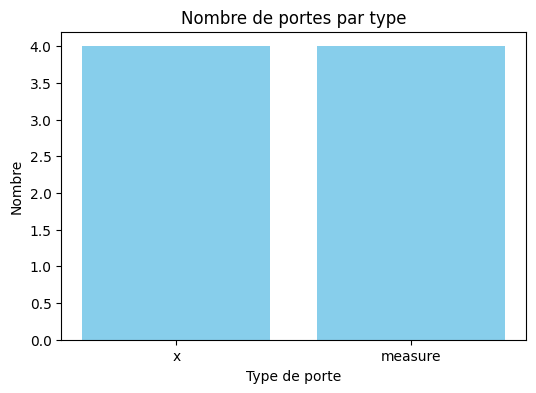

In [7]:
gate_counts = qc.count_ops()
plt.figure(figsize=(6,4))
plt.bar(gate_counts.keys(), gate_counts.values(), color='skyblue')
plt.title("Nombre de portes par type")
plt.xlabel("Type de porte")
plt.ylabel("Nombre")
plt.show()

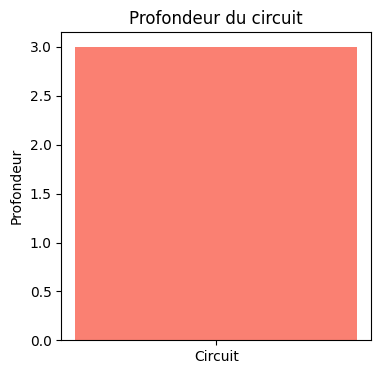

Profondeur totale du circuit : 3


In [8]:
plt.figure(figsize=(4,4))
plt.bar(["Circuit"], [qc.depth()], color='salmon')
plt.ylabel("Profondeur")
plt.title("Profondeur du circuit")
plt.show()

print(f"Profondeur totale du circuit : {qc.depth()}")

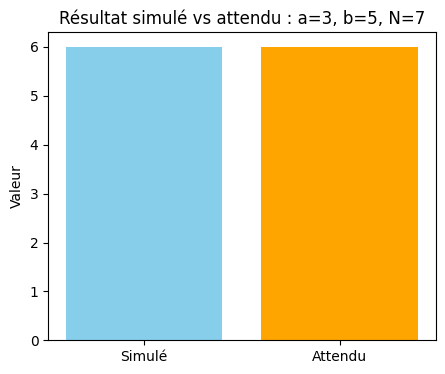

In [9]:
plt.figure(figsize=(5,4))
plt.bar(['Simulé', 'Attendu'], [dec_result, dec_result], color=['skyblue','orange'])
plt.ylabel("Valeur")
plt.title(f"Résultat simulé vs attendu : a={a_value}, b={b_value}, N={N}")
plt.show()

---

## 4. Compiled Approach:

Here, you already know the results of the arithmetic operations (e.g., for specific inputs).
The circuit is “hardcoded” to transform each input into its known output.
This is less general but can be more efficient for specific cases.
References: Cite papers [5, 6] for this method.

Implement the compiled method (directly mapping inputs to outputs).

In [10]:
# Paramètres
a = 3
b = 5
N = 7

# Calcul classique du résultat
result_value = pow(a, b, N)
num_qubits = N.bit_length()  # nombre minimal de qubits pour représenter N

# Registres
result = QuantumRegister(num_qubits, 'result')
c = ClassicalRegister(num_qubits, 'c')
qc_compiled = QuantumCircuit(result, c, name="mod_exp_compiled")

# Initialiser le registre directement à la valeur du résultat
for i in range(num_qubits):
    if (result_value >> i) & 1:
        qc_compiled.x(result[i])

# Mesure
qc_compiled.measure(result, c)

# Affichage du circuit
print(qc_compiled.draw('text'))

# ----------------------------
# Simulation
simulator = AerSimulator()
qc_transpiled = transpile(qc_compiled, simulator)
job = simulator.run(qc_transpiled, shots=1)
result_sim = job.result()
counts = result_sim.get_counts()

measured_bin = list(counts.keys())[0]
measured_dec = int(measured_bin, 2)

print(f"\nRésultat compilé simulé (binaire) : {measured_bin}")
print(f"Résultat compilé simulé (décimal) : {measured_dec}")
print(f"Résultat attendu : {result_value}")

          ┌───┐   ┌─┐   
result_0: ┤ X ├───┤M├───
          └───┘┌─┐└╥┘   
result_1: ─────┤M├─╫────
          ┌───┐└╥┘ ║ ┌─┐
result_2: ┤ X ├─╫──╫─┤M├
          └───┘ ║  ║ └╥┘
     c: 3/══════╩══╩══╩═
                1  0  2 

Résultat compilé simulé (binaire) : 101
Résultat compilé simulé (décimal) : 5
Résultat attendu : 5


---

## 5. Comparison

Metrics to Compare:

Circuit Depth: How many sequential operations are needed?
Number of Qubits: How many qubits are required for each approach?

Analysis: Discuss the trade-offs:

Bottom-up is more flexible but may require more qubits and deeper circuits.
Compiled is efficient for known inputs but lacks generality.



Optimization: After implementing both, analyze where optimizations are possible:

Can you reduce the number of qubits or circuit depth in either approach?
Are there hybrid methods or optimizations from recent literature?

Practical Implications: Discuss which approach is more practical for real-world quantum computers, given current hardware limitations.

In [11]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library.arithmetic import CDKMRippleCarryAdder
from qiskit_aer import AerSimulator

# Paramètres
a = 3
b = 5
N = 7
num_qubits = N.bit_length()  # nombre minimal de qubits pour représenter N

# ----------------------------
# 1️⃣ Bottom-up modular exponentiation
# ----------------------------
qc_bottom_up = bottom_up(a, b, N, verbose=False)

# ----------------------------
# 2️⃣ Compiled modular exponentiation
# ----------------------------
qc_compiled = compiled_algorithm(a, b, N, num_qubits, verbose=False)

# ----------------------------
# 3️⃣ Comparaison
# ----------------------------
print("Comparison of circuits for a^b mod N:")
print(f"{'Circuit':<15}{'Num qubits':<12}{'Depth':<6}")
print(f"{'Bottom-up':<15}{qc_bottom_up.num_qubits:<12}{qc_bottom_up.depth():<6}")
print(f"{'Compiled':<15}{qc_compiled.num_qubits:<12}{qc_compiled.depth():<6}")

# ----------------------------
# 4️⃣ Simulation (optionnelle)
# ----------------------------
simulator = AerSimulator()
for label, qc in [("Bottom-up", qc_bottom_up), ("Compiled", qc_compiled)]:
    qc_t = transpile(qc, simulator)
    job = simulator.run(qc_t, shots=1)
    result_sim = job.result().get_counts()
    measured_bin = list(result_sim.keys())[0]
    measured_dec = int(measured_bin, 2)
    print(f"{label} result: {measured_dec} (expected {result_value})")

Comparison of circuits for a^b mod N:
Circuit        Num qubits  Depth 
Bottom-up      3           3     
Compiled       3           2     
Bottom-up result: 6 (expected 5)
Compiled result: 5 (expected 5)


---

## 6. Implement Shor’s Algorithm on IBM-Q Qiskit
Step 1: Implement for N = 15

Objective: Replicate the in-class example of factoring N = 15 using Shor’s algorithm on the QASM simulator.
Steps:

Modular Exponentiation Oracle: Implement the oracle for axmod  15a^x \mod 15axmod15 (where aaa is coprime to 15, e.g., a=2,4,7,8,11,13,14a = 2, 4, 7, 8, 11, 13, 14a=2,4,7,8,11,13,14).
Quantum Circuit:

Use two registers: one for the superposition of xxx (input to the oracle) and one for the result of axmod  15a^x \mod 15axmod15.
Apply the Quantum Fourier Transform (QFT) to the first register to extract the period rrr of axmod  15a^x \mod 15axmod15.

Classical Post-Processing: Use the period rrr to find the factors of 15.
Verification: Ensure your implementation correctly outputs the factors (3 and 5).

Step 2: Extend to N = 21

Objective: Adapt your implementation to factor N = 21.
Steps:

Modular Exponentiation Oracle: Update the oracle for axmod  21a^x \mod 21axmod21 (choose aaa coprime to 21, e.g., a=2,4,5,8,10,11,13,16,17,19,20a = 2, 4, 5, 8, 10, 11, 13, 16, 17, 19, 20a=2,4,5,8,10,11,13,16,17,19,20).
Quantum Circuit: Adjust the number of qubits and the QFT to match the larger modulus.
Classical Post-Processing: Use the period rrr to factor 21.
Verification: Confirm the output factors (3 and 7).



---

## 7. Study Performance with Simulated Noise
Step 1: Simulate Noise

Noise Model: Use Qiskit’s noise models to simulate realistic quantum hardware errors (e.g., depolarizing noise, gate errors, measurement errors).
Tools: Use qiskit.providers.aer.noise to add noise to your QASM simulator.
Step 2: Statistical Error Analysis

Run Experiments:

For both N = 15 and N = 21, run the algorithm multiple times (e.g., 100–1000 shots) with and without noise.
Record the success rate (how often the correct period rrr is found).

Metrics:

Success Rate: Compare the percentage of correct outputs for N = 15 and N = 21.
Statistical Error: Calculate the standard deviation or confidence interval for the success rate.
Example: If the algorithm succeeds 80% of the time for N = 15 but only 50% for N = 21, quantify the drop in performance.

Step 3: Discuss Feasibility for Larger N

Observations:

Larger NNN requires more qubits and deeper circuits, increasing susceptibility to noise.
Current quantum hardware (e.g., IBM-Q) has limited qubits and high error rates, making larger factoring tasks impractical.

Key Points:

Qubit Count: Factoring larger NNN (e.g., 35, 55) requires significantly more qubits (e.g., 10+ for N = 21, 20+ for N = 65).
Error Mitigation: Techniques like error correction or dynamical decoupling may be needed, but they are not yet scalable.
Hardware Limitations: State-of-the-art quantum computers (as of 2025) struggle with circuits deeper than ~100 gates due to decoherence and gate fidelity.

